# Block by Block - Two Turn - DeepSeek
- Second prompt after output about answer in /boxed{}
- vLLM in fp16


### TODO:
1. Use string output in case there is no code output
2. Feed error message into code retries
3. Submit to Kaggle

In [1]:
import os, io
import json
import uuid
from pathlib import Path
from datetime import datetime
import re, sys, subprocess, gc
import time
import multiprocessing
import statsmodels.api as sm

import pandas as pd
import numpy as np
import torch
from vllm import LLM, SamplingParams
from multiprocessing import Pool

n_questions = 500
n_reps_per_prompt = 3
n_code_retries = 4
code_timeout_secs = 2
temperature = 0.9
code_temperature = 0.3
n_code_processes = 8

np.random.seed(42)

def free_mem():
    if hasattr(sys, 'last_traceback'):
        sys.last_traceback.tb_next = None
    gc.collect()
    torch.cuda.empty_cache()

def print_cuda_mem():
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
    cached_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)
    available_memory = total_memory - cached_memory 
    print(f"Available Memory (GB, approx.): {available_memory:.2f}")

ds_math_rl = "deepseek-ai/deepseek-math-7b-rl"
#"mixtral · 8x7b-instruct-v0.1-hf" ???


torch_dtype = torch.bfloat16
# to avoid warning when spawing processes to evaluate code later
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
print_cuda_mem()

if not 'vllm' in globals():
    vllm = LLM(model=ds_math_rl,
               dtype='half',
               enforce_eager=True,
               gpu_memory_utilization=0.99,
               swap_space=4,
               max_model_len=2048,
               kv_cache_dtype="fp8_e5m2",
               tensor_parallel_size=1)
vtokenizer = vllm.get_tokenizer()

Available Memory (GB, approx.): 23.64
WARNING 04-30 10:28:10 config.py:767] Casting torch.bfloat16 to torch.float16.
INFO 04-30 10:28:10 config.py:381] Using fp8_e5m2 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. But it may cause slight accuracy drop. Currently we only support fp8 without scaling factors and make e5m2 as a default format.
INFO 04-30 10:28:10 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='deepseek-ai/deepseek-math-7b-rl', tokenizer='deepseek-ai/deepseek-math-7b-rl', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=True, kv_cache_dtype=fp8_e5m2, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 04-30 10:28:11 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
INFO 04-30 10:28:11 selector.py:25] Using XFormers backend.
INFO 04-30 10:28:12 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-30 10:28:15 model_runner.py:104] Loading model weights took 12.8725 GB
INFO 04-30 10:28:15 gpu_executor.py:94] # GPU blocks: 2569, # CPU blocks: 1092


In [2]:
free_mem()

In [3]:
q_df = pd.read_csv('./train.csv')
print(q_df.iloc[0]['problem'])
q_df.iloc[0]['answer']
q_df[:3]

Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?


,id,problem,answer
0,229ee8,"Let $k, l > 0$ be parameters. The parabola $y ...",52
1,246d26,Each of the three-digits numbers $111$ to $999...,250
2,2fc4ad,Let the `sparkle' operation on positive intege...,702


In [4]:
from MATH.math_equivalence import is_equiv
def extract_answer(text, boxed_in_tool_instruction=True):
    pattern = r"\\boxed\{([^}]*)\}"
    matches = re.findall(pattern, text)
    n_matches = 2 if boxed_in_tool_instruction else 1
    
    if len(matches) >= n_matches:
        try:
            return int(matches[-1]) % 1000
        except ValueError:
            return None

    numbers = re.findall(r'[+-]?\d+', text)
    return int(numbers[-1]) % 1000 if numbers else -1

def extract_correct(text):
    return extract_answer(text, False)

def read_math_data(folder_path, train_test):
    folder = Path(folder_path)
    math_data = []
    for sub_folder in os.listdir(folder):
        if not os.path.isdir(folder/sub_folder):
            continue
        for file_name in os.listdir(folder/sub_folder):
            if file_name.endswith('.json'):
                with open(folder / sub_folder / file_name, 'r') as file:
                    data = json.load(file)
                    data['id'] = train_test + '-' + sub_folder + '-' + file_name[:-5]
                    math_data.append(data)
    return pd.DataFrame(math_data)

math_train = read_math_data('./MATH/train', 'train')
math_train['answer'] = math_train['solution'].map(extract_correct)
math_train = math_train[math_train['answer'].notnull()]
math_train['answer'] = math_train['answer'].astype(int)
math_test = read_math_data('./MATH/test', 'test')
math_test['answer'] = math_test['solution'].map(extract_correct)
math_test = math_test[math_test['answer'].notnull()]
math_test['answer'] = math_test['answer'].astype(int)
print(math_train.shape, math_test.shape)

(4748, 6) (3119, 6)


- 1 yes
- 2 no
- 3 no
- 4 yes
- 5 maybe
- 6 maybe
- 7 yes
- 8 maybe
- 9 yes
- 10 no

In [5]:
math_samp = math_test[math_test['level'].isin(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])].sample(n_questions)
math_samp.columns

Index(['problem', 'level', 'type', 'solution', 'id', 'answer'], dtype='object')

In [6]:
# with pd.option_context('display.max_rows', None):
display(math_samp[:3])

,problem,level,type,solution,id,answer
2857,Given $2^a = 32$ and $a^b = 125$ find $b^a$.,Level 1,Algebra,We note that $32 = 2 \cdot 2\cdot 2\cdot 2\cdo...,test-algebra-756,243
3540,How many distinct three-letter sequences with ...,Level 5,Counting & Probability,We solve by casework.\n\n$\bullet$ Case I: Exa...,test-counting_and_probability-381,48
3975,Compute $\cos 180^\circ$.,Level 1,Precalculus,"Rotating the point $(1,0)$ about the origin by...",test-precalculus-1282,999


In [7]:
math_test[math_test['id'].str.contains('808')]

,problem,level,type,solution,id,answer
381,"On a number line, the coordinates of $P$ and $...",Level 5,Prealgebra,"Since $B$ is midpoint of $\overline{PQ}$, the ...",test-prealgebra-808,23
1083,"There are many two-digit multiples of 7, but o...",Level 2,Number Theory,"The two-digit multiples of 7 are $$14, 21, \un...",test-number_theory-808,119
1795,Let $f(x)$ be a polynomial of degree $4$ with ...,Level 4,Intermediate Algebra,"Since $f$ has rational coefficients, $1-2\sqrt...",test-intermediate_algebra-808,952
4210,For some matrix $\mathbf{P} = \begin{pmatrix} ...,Level 4,Precalculus,From the equation $\begin{pmatrix} 4 & 3 \\ -1...,test-precalculus-808,6
4734,"In $\triangle ABC$, what is the value of $x + ...",Level 1,Geometry,"Since $\triangle BDA$ is isosceles, $\angle BA...",test-geometry-808,90


# Batched Inference

In [8]:
short_instruction = "\nPlease reason step by step and use Python code. The final answer is an integer and should be placed within \\boxed{}."
short_code_instruction = "\nDescribe a high level strategy to solve the problem. Output Python with SymPy code to solve the problem. The final answer is an integer and should be placed within \\boxed{}."
derive_instruction_long = "\nFirst translate the problem into equations and try to derive useful other equations.\n" \
                          + "Then use Python code to solve the problem. The final answer is an integer and should be placed within \\boxed{}."
early_win_instruction = """\nTo solve the problem first determine a sympy-based approach for solving the problem by listing each step to take and what functions need to be called in each step.\n
Write a Python script covering all the steps and print the result. The final answer is an integer and should be placed within \\boxed{}.

Approach:"""

prompt_variations = {
    'short_instruction' : short_instruction,
    'short_code_instruction' : short_code_instruction,
    'derive_instruction_long': derive_instruction_long,
    'early_win_instruction': early_win_instruction
}

In [9]:
batched_prompts = []
out_rows = []
for rep in range(n_reps_per_prompt):
    for inst_idx, inst_key_val in enumerate(prompt_variations.items()):
        for i, problem in enumerate(math_samp['problem']):
            prompt = problem + inst_key_val[1]
            messages = [{"role": "user", "content": prompt}]
            m_prompt = vtokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
            batched_prompts.append(m_prompt)
            out_rows.append({
                'problem_id': math_samp.iloc[i]['id'],
                'problem': math_samp.iloc[i]['problem'],
                'correct_answer': math_samp.iloc[i]['answer'],
                'iteration': 0,
                'rep': rep * len(prompt_variations) + inst_idx,
                'level': math_samp.iloc[i]['level'],
                'type': math_samp.iloc[i]['type'],
                'prompt_variation': inst_key_val[0],
                'prompt': m_prompt
            })
    
tool_sampling_params = SamplingParams(n=1,
                                      temperature=temperature,
                                      max_tokens=1824,
                                      stop='python',
                                      include_stop_str_in_output=True)
before_code_out = vllm.generate(batched_prompts, tool_sampling_params)

n_out_tokens = 0
for i, output in enumerate(before_code_out):
    out_rows[i]['out_before_code'] = output.outputs[0].text
    out_rows[i]['n_before_code_tokens'] = len(output.outputs[0].token_ids)

df_res = pd.DataFrame(out_rows)
df_res[:2]


Processed prompts: 100%|██████████| 6000/6000 [10:40<00:00,  9.37it/s]


,problem_id,problem,correct_answer,iteration,rep,level,type,prompt_variation,prompt,out_before_code,n_before_code_tokens
0,test-algebra-756,Given $2^a = 32$ and $a^b = 125$ find $b^a$.,243,0,0,Level 1,Algebra,short_instruction,<｜begin▁of▁sentence｜>User: Given $2^a = 32$ an...,"First, we solve the equation $2^a = 32$ for $...",123
1,test-counting_and_probability-381,How many distinct three-letter sequences with ...,48,0,0,Level 5,Counting & Probability,short_instruction,<｜begin▁of▁sentence｜>User: How many distinct t...,We can approach this problem by finding the t...,138


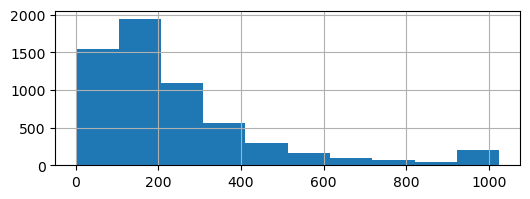

In [10]:
_= df_res['n_before_code_tokens'].hist(figsize=(6,2))

### !!! Most answers before the code already tried to completely answer the question.

### ToDo: Try out a code focussed instruction for code generation

In [11]:
i = -1

In [12]:
i += 1
df_res['level'].iloc[i], df_res['problem'].iloc[i], df_res['correct_answer'].iloc[i]

('Level 1', 'Given $2^a = 32$ and $a^b = 125$ find $b^a$.', 243)

In [13]:
df_res['out_before_code'].iloc[i]

' First, we solve the equation $2^a = 32$ for $a$.\n\n$32 = 2^5$, so $a = 5$.\n\nNext, we substitute $a = 5$ into the equation $a^b = 125$ and solve for $b$.\n\n$125 = 5^3$, so $b = 3$.\n\nFinally, we substitute $a = 5$ and $b = 3$ into the expression $b^a$ to find its value.\n\n```python'

In [14]:
df_res['code_prompt'] = df_res['prompt'] + df_res['out_before_code']
python_rows = df_res['code_prompt'].str.endswith('python')
df_res.loc[~python_rows, 'code_prompt'] += "\n```python\n"

code_sampling_params = SamplingParams(n=1,
                                      temperature=code_temperature,
                                      max_tokens=1024,
                                      stop='```')
code_out = vllm.generate(df_res['code_prompt'], code_sampling_params)

code_results = []
n_code_tokens = []
for output in code_out:
    code_results.append(output.outputs[0].text)
    n_code_tokens.append(len(output.outputs[0].token_ids))
df_res['code'] = code_results
df_res['n_code_tokens'] = n_code_tokens

Processed prompts: 100%|██████████| 6000/6000 [08:25<00:00, 11.86it/s]


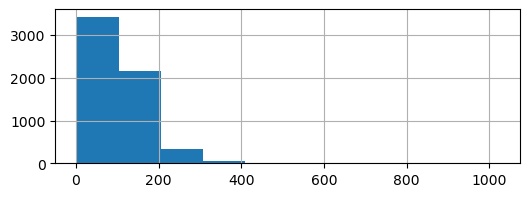

In [15]:
_= df_res['n_code_tokens'].hist(figsize=(6,2))

In [16]:
def parse_code(output):
    if '```python\n' in output:
        try:
            output = output.split(python_code_prefix)[-1]
        except:
            return None   
    if '```' in output:
        output = output.split('```')[0]
    #output = python_default_imports + output
    return add_workarounds(output)

def add_workarounds(code):
    import re
    def repl(match):
        if "real" not in match.group():
            return "{}{}".format(match.group()[:-1], ', real=True)')
        else:
            return "{}{}".format(match.group()[:-1], ')')
    code = re.sub(r"symbols\([^)]+\)", repl, code)
    
    pattern = r"\s(?:cbrt|root)\((.*?)(?:, 3)?\)"
    replacement = r"real_root(\1, 3)"
    code = re.sub(pattern, replacement, code)
    code = re.sub(r'permutations\(', 'itertools.permutations(', code)
    
    code = 'from sympy import *\nimport math, itertools\n' + code
    if 'np.' in code:
        code = 'import numpy as np\n' + code
    return code

def run_with_timeout(code, timeout):
    #ToDo: check whether sometimes there is a print of the corect result before an exception
    
    unique_filename = f'code_{uuid.uuid4().hex}.py'
    with open(unique_filename, 'w') as fout:
        fout.write(code)

    batcmd = f'timeout {timeout} {sys.executable} {unique_filename}'
    try:
        shell_output = subprocess.check_output(batcmd, stderr=subprocess.STDOUT, shell=True).decode('utf8')
    except subprocess.CalledProcessError as e:
        shell_output = e.output.decode('utf8')  # Get the output which may include Python error messages
    try:
        out_eval = eval(shell_output.strip())
        if type(out_eval) == list:
            out_eval = out_eval[0]
        code_output = round(float(out_eval)) % 1000  # <----------   !!!!!!!!!!!!   modulo important for competition
    except Exception as e:
        code_output = shell_output
    os.remove(unique_filename)
    return code_output

def parse_and_run(code):
    try:
        code = parse_code(code)
    except Exception as ex:
        return str(ex)
    try:
        return run_with_timeout(code, code_timeout_secs)
    except Exception as ex:
        return str(ex)
    
def run_code_parallel(code_series):
    with Pool(processes=n_code_processes) as pool:
        return pool.map(parse_and_run, [item for item in code_series])

In [17]:
df_res['parsed_code'] = df_res['code'].map(parse_code)
start_time = time.time()
df_res['code_result'] = run_code_parallel(df_res['code'])
print(f"Ran code outputs in {round(time.time() - start_time)}s")

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


Ran code outputs in 142s


In [18]:
df_res[df_res['code_result'].str.contains('.py').fillna(False)].shape

(549, 16)

In [19]:
df_res['code_result'].str.contains('Traceback').sum()

391

In [20]:
df_res['int_code_result'] = pd.to_numeric(df_res['code_result'], errors='coerce')
df_res['int_code_result'] = df_res['int_code_result'].fillna(-1).astype(int)

In [21]:
df_res['code_prompt'].iloc[2]

"<｜begin▁of▁sentence｜>User: Compute $\\cos 180^\\circ$.\nPlease reason step by step and use Python code.\n\nAssistant: The value of $\\cos 180^\\circ$ is $-1$. This is a well-known value in trigonometry. Here's a Python code to confirm it:\n\n```python"

In [22]:
df_res['code_result'].iloc[0]

243

In [23]:
increasing_code_temperature = code_temperature

for i in range(n_code_retries):
    if increasing_code_temperature <= 0.8:
        increasing_code_temperature += 0.2
    else:
        increasing_code_temperature = 1
      
    missing = df_res[df_res['int_code_result'] == -1]
    print(f"{len(missing)} missing or non-numerical code results")
    last_error_lines = missing['code_result'].str.split('\n').apply(lambda x: '\n'.join(x[-10:]))
    missing['code_prompt'] = missing['code_prompt'].str.slice(0, -10) + '\nTry to avoid this error from the previous attempt: \n\n' \
                            + last_error_lines + '\n\n```python\n'
    
    if len(missing['code_prompt']) > 0:
        print(missing['code_prompt'].iloc[0])
    code_out = vllm.generate(missing['code_prompt'].values, code_sampling_params)

    n_out_tokens = 0
    code_results = []
    n_code_tokens = []
    for output in code_out:
        code_results.append(output.outputs[0].text)
        n_code_tokens.append(len(output.outputs[0].token_ids))
    df_res.loc[missing.index, 'code'] = code_results
    df_res.loc[missing.index, 'n_code_tokens'] = n_code_tokens

    start_time = time.time()
    df_res.loc[missing.index, 'code_result'] = run_code_parallel(df_res.loc[missing.index, 'code'])
    print(f"Ran code outputs in {round(time.time() - start_time)}s")
    
    df_res.loc[missing.index, 'int_code_result'] = pd.to_numeric(df_res.loc[missing.index ,'code_result'], errors='coerce')
    df_res['int_code_result'] = df_res['int_code_result'].fillna(-1).astype(int)
missing = df_res[df_res['int_code_result'] == -1]
print(f"{len(missing)} missing or non-numerical code results")

1351 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: Evaluate: $[1-(-1)^{11}]^2.$
Please reason step by step and use Python code.

Assistant: To evaluate the expression $[1-(-1)^{11}]^2$, we first need to evaluate $(-1)^{11}$.

In Python, we can compute $(-1)^{11}$ as follows:

Try to avoid this error from the previous attempt: 



```python



/tmp/ipykernel_117515/704127510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = missing['code_prompt'].str.slice(0, -10) + '\nTry to avoid this error from the previous attempt: \n\n' \
Processed prompts:  21%|██        | 278/1351 [00:44<02:35,  6.90it/s]

WARNING 04-30 10:50:36 scheduler.py:245] Input prompt (2454 tokens) is too long and exceeds limit of 2048


Processed prompts: 100%|██████████| 1351/1351 [03:16<00:00,  6.87it/s]
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


Ran code outputs in 44s
938 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: How many distinct rectangles are there with integer side lengths such that the numerical value of area of the rectangle in square units is equal to $5$ times the numerical value of the perimeter in units? (Two rectangles are considered to be distinct if they are not congruent.)
Please reason step by step and use Python code.

Assistant: Let the side lengths of the rectangle be $x$ and $y$. The area of the rectangle is $A = xy$ and the perimeter is $P = 2(x+y)$. We are given that $A = 5P$, so $xy = 5(2(x+y))$. Simplifying, we have $xy = 10x + 10y$. Rearranging the terms, we get $xy - 10x - 10y = 0$. Adding 100 to both sides, we get $xy - 10x - 10y + 100 = 100$, which can be rewritten as $(x-10)(y-10) = 100$.

Now, we can find all the pairs of positive factors of 100 and for each pair, set $x-10$ to one factor and $y-10$ to the other. Then, we will add 10 to both sides of the equations to get the

/tmp/ipykernel_117515/704127510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = missing['code_prompt'].str.slice(0, -10) + '\nTry to avoid this error from the previous attempt: \n\n' \
Processed prompts: 100%|██████████| 938/938 [02:31<00:00,  6.20it/s]
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


Ran code outputs in 32s
829 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: How many distinct rectangles are there with integer side lengths such that the numerical value of area of the rectangle in square units is equal to $5$ times the numerical value of the perimeter in units? (Two rectangles are considered to be distinct if they are not congruent.)
Please reason step by step and use Python code.

Assistant: Let the side lengths of the rectangle be $x$ and $y$. The area of the rectangle is $A = xy$ and the perimeter is $P = 2(x+y)$. We are given that $A = 5P$, so $xy = 5(2(x+y))$. Simplifying, we have $xy = 10x + 10y$. Rearranging the terms, we get $xy - 10x - 10y = 0$. Adding 100 to both sides, we get $xy - 10x - 10y + 100 = 100$, which can be rewritten as $(x-10)(y-10) = 100$.

Now, we can find all the pairs of positive factors of 100 and for each pair, set $x-10$ to one factor and $y-10$ to the other. Then, we will add 10 to both sides of the equations to get the

/tmp/ipykernel_117515/704127510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = missing['code_prompt'].str.slice(0, -10) + '\nTry to avoid this error from the previous attempt: \n\n' \
Processed prompts:  20%|█▉        | 163/829 [00:28<03:49,  2.90it/s]

WARNING 04-30 10:57:26 scheduler.py:245] Input prompt (2449 tokens) is too long and exceeds limit of 2048


Processed prompts: 100%|██████████| 829/829 [02:09<00:00,  6.38it/s]
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


Ran code outputs in 31s
782 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: How many distinct rectangles are there with integer side lengths such that the numerical value of area of the rectangle in square units is equal to $5$ times the numerical value of the perimeter in units? (Two rectangles are considered to be distinct if they are not congruent.)
Please reason step by step and use Python code.

Assistant: Let the side lengths of the rectangle be $x$ and $y$. The area of the rectangle is $A = xy$ and the perimeter is $P = 2(x+y)$. We are given that $A = 5P$, so $xy = 5(2(x+y))$. Simplifying, we have $xy = 10x + 10y$. Rearranging the terms, we get $xy - 10x - 10y = 0$. Adding 100 to both sides, we get $xy - 10x - 10y + 100 = 100$, which can be rewritten as $(x-10)(y-10) = 100$.

Now, we can find all the pairs of positive factors of 100 and for each pair, set $x-10$ to one factor and $y-10$ to the other. Then, we will add 10 to both sides of the equations to get the

/tmp/ipykernel_117515/704127510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = missing['code_prompt'].str.slice(0, -10) + '\nTry to avoid this error from the previous attempt: \n\n' \
Processed prompts: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s]
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Ran code outputs in 27s
743 missing or non-numerical code results


### Inspect code errors

In [32]:
missing['code_prompt'].iloc[0]

'<｜begin▁of▁sentence｜>User: How many distinct rectangles are there with integer side lengths such that the numerical value of area of the rectangle in square units is equal to $5$ times the numerical value of the perimeter in units? (Two rectangles are considered to be distinct if they are not congruent.)\nPlease reason step by step and use Python code.\n\nAssistant: Let the side lengths of the rectangle be $x$ and $y$. The area of the rectangle is $A = xy$ and the perimeter is $P = 2(x+y)$. We are given that $A = 5P$, so $xy = 5(2(x+y))$. Simplifying, we have $xy = 10x + 10y$. Rearranging the terms, we get $xy - 10x - 10y = 0$. Adding 100 to both sides, we get $xy - 10x - 10y + 100 = 100$, which can be rewritten as $(x-10)(y-10) = 100$.\n\nNow, we can find all the pairs of positive factors of 100 and for each pair, set $x-10$ to one factor and $y-10$ to the other. Then, we will add 10 to both sides of the equations to get the side lengths $x$ and $y$.\n\n```python'

In [33]:
rows = df_res['int_code_result'] == -1
i = -1

In [34]:
i += 1
i

0

In [35]:
print(df_res[rows]['problem'].iloc[i])

How many distinct rectangles are there with integer side lengths such that the numerical value of area of the rectangle in square units is equal to $5$ times the numerical value of the perimeter in units? (Two rectangles are considered to be distinct if they are not congruent.)


In [36]:
print(df_res[rows]['parsed_code'].iloc[i])

from sympy import *
import math, itertools

import math

def find_rectangles():
    rectangles = []
    for i in range(1, int(math.sqrt(100)) + 1):
        if 100 % i == 0:
            pair = (i, 100 // i)
            x = pair[0] + 10
            y = pair[1] + 10
            rectangles.append((x, y))
    return rectangles

rectangles = find_rectangles()
print(len(rectangles))
print(rectangles)



In [37]:
print(run_with_timeout(df_res[rows]['parsed_code'].iloc[i], 3))

5
[(11, 110), (12, 60), (14, 35), (15, 30), (20, 20)]



In [38]:
print(run_with_timeout(df_res[rows]['parsed_code'].iloc[i], 3))

5
[(11, 110), (12, 60), (14, 35), (15, 30), (20, 20)]



In [39]:
df_res['code_result'].astype(str).str.slice(0, 10).values[:100]

array(['243', '152', '999', '10', '80', '2', '4', '997', '40', '40', '23',
       '993', '75', '42', '21', '21', '78', '13', '1', '4', '11', '1',
       '4', '6', '500', '1', '[(11, 110)', '0', '1', '9', '999', '3', '0',
       '999', '7', '2', '5', '1', 'Traceback ', '1', '8', '', '190', '31',
       '16', '672', 'Traceback ', '998', '100', '840', '4', '6', '12',
       '0', '21', '10', '9', '9', '20', '624', '0', '36', '129', '16',
       '3', 'Traceback ', '334', '3', 'x*y*z + 3*', '4', '998', '1', '2',
       'Traceback ', '8', '348', '2', '985', '170.666666', '80', '16',
       '20', '5', '11', '13', '  File "/h', '3*sqrt(5) ', '7', '90',
       '999', '2', '12', '18', '1', '80', '668', '230', '5', '992', '56'],
      dtype=object)

## Use output to generate answer

In [58]:
continue_postfix = "}<｜end▁of▁sentence｜>User: {Answer the question above using the output of the code.  .}\n\n Assistant:"

df_res['continue_prompt'] = df_res['code_prompt'] + df_res['code'] +'```\n```output\n' + df_res['code_result'].astype(str).str.slice(0, 10) + '\n```\n' \
                                                  + continue_postfix + '\n\n'

tool_sampling_params = SamplingParams(n=1,
                                      temperature=temperature,
                                      max_tokens=2048)
llm_out = vllm.generate(df_res['continue_prompt'], tool_sampling_params)

continuations = []
n_continue_tokens = []
for llm_output in llm_out:
    continuations.append(llm_output.outputs[0].text)
    n_continue_tokens.append(len(llm_output.outputs[0].token_ids))
    
df_res['continuations'] = continuations
df_res['n_continue_tokens'] = n_continue_tokens
df_res['combined'] = df_res['continue_prompt'] + df_res['continuations']

Processed prompts:   2%|▏         | 98/6000 [00:15<14:57,  6.57it/s] 

WARNING 04-30 12:58:22 scheduler.py:245] Input prompt (2066 tokens) is too long and exceeds limit of 2048


Processed prompts: 100%|██████████| 6000/6000 [21:22<00:00,  4.68it/s]


In [59]:
# file_name = 'block_by_block_results_april_29.csv'
# df_res.to_csv(file_name, index=False)
# df_res = pd.read_csv(file_name)
# df_res['problem_id'] = df_res['problem_id'].astype(str)

In [60]:
def standardize_number(number):
    try:
        return int(number)
    except:pass
    try:
        return float(number)
    except: pass
    return -1

In [61]:
df_res['llm_result'] = df_res['combined'].map(extract_answer)
df_res['combined_result'] = df_res['code_result'].fillna(df_res['llm_result'])

## Count Correct

In [75]:
def first_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

In [76]:
most_common = df_res.groupby('problem_id')['llm_result'].agg(first_mode)
most_common = most_common.apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) >= 1 else x)
most_common = pd.DataFrame(most_common).reset_index()
pooled = math_samp.merge(most_common, left_on='id', right_on='problem_id')
is_correct = []
for row in pooled.iterrows():
    correct = standardize_number(row[1]['llm_result'])
    result = standardize_number(row[1]['answer'])
    is_correct.append(is_equiv(correct, result))
pooled['is_correct'] = is_correct

In [77]:
def logistic_mean_and_cis(binary_series):
    ci_lower, ci_upper = sm.stats.proportion_confint(count=binary_series.sum(), nobs=len(binary_series), alpha=0.05, method='agresti_coull')
    return f"{round(binary_series.mean(),2)} with CI  {round(ci_lower,2)}-{round(ci_upper,2)}"
    
logistic_mean_and_cis(pooled['is_correct'])

'0.7 with CI  0.66-0.74'

In [78]:
pooled.groupby('level')['is_correct'].agg(logistic_mean_and_cis)

level
Level 1    0.92 with CI  0.82-0.97
Level 2    0.83 with CI  0.73-0.89
Level 3     0.78 with CI  0.7-0.85
Level 4    0.66 with CI  0.57-0.74
Level 5    0.46 with CI  0.37-0.55
Name: is_correct, dtype: object

In [79]:
most_common = df_res.groupby(['problem_id', 'prompt_variation'])['llm_result'].agg(first_mode)
most_common = most_common.apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) >= 1 else x)
most_common = pd.DataFrame(most_common).reset_index()
most_common

,problem_id,prompt_variation,llm_result
0,test-algebra-1022,derive_instruction_long,985.0
1,test-algebra-1022,early_win_instruction,0.0
2,test-algebra-1022,short_code_instruction,0.0
3,test-algebra-1022,short_instruction,2.0
4,test-algebra-1065,derive_instruction_long,16.0
...,...,...,...
1995,test-precalculus-984,short_instruction,5.0
1996,test-precalculus-991,derive_instruction_long,988.0
1997,test-precalculus-991,early_win_instruction,988.0
1998,test-precalculus-991,short_code_instruction,988.0


In [80]:
prompt_grouped = math_samp.merge(most_common, left_on='id', right_on='problem_id')
is_correct = []
for row in prompt_grouped.iterrows():
    correct = standardize_number(row[1]['llm_result'])
    result = standardize_number(row[1]['answer'])
    is_correct.append(is_equiv(correct, result))
prompt_grouped['is_correct'] = is_correct

In [81]:
import seaborn as sns

<Axes: xlabel='prompt_variation', ylabel='is_correct'>

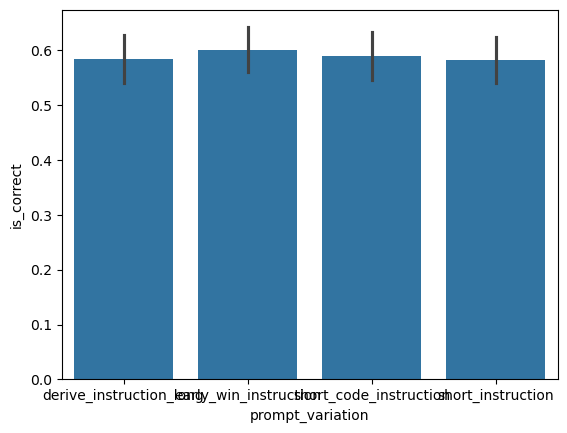

In [82]:
sns.barplot(prompt_grouped, x='prompt_variation', y='is_correct')

In [70]:
print(prompt_grouped['is_correct'].mean())
prompt_grouped.groupby('prompt_variation')['is_correct'].agg(['size', 'mean'])

0.589


,size,mean
prompt_variation,,
derive_instruction_long,500,0.584
early_win_instruction,500,0.600
short_code_instruction,500,0.590
short_instruction,500,0.582


In [71]:
prompt_grouped.groupby('prompt_variation')['is_correct'].agg(['size', 'mean'])

,size,mean
prompt_variation,,
derive_instruction_long,500,0.584
early_win_instruction,500,0.600
short_code_instruction,500,0.590
short_instruction,500,0.582


```
0.692
size	mean
level		
Level 1	23	0.826087
Level 2	49	0.816327
Level 3	66	0.787879
Level 4	68	0.647059
Level 5	44	0.409091
```

In [ ]:
df_res.to_csv('inject_code_results_april_23_2000.csv', index=False)

In [116]:
pooled.columns

Index(['problem', 'level', 'type', 'solution', 'id', 'answer', 'problem_id',
       'llm_result', 'is_correct'],
      dtype='object')

In [128]:
with pd.option_context('display.max_rows', None):
    display(pooled.loc[(pooled['level'] == 'Level 1') & (~pooled['is_correct']), ['id', 'level', 'type', 'answer', 'llm_result', 'is_correct']])

,id,level,type,answer,llm_result,is_correct
15,1016,Level 1,Counting & Probability,17,21.0,False
47,808,Level 1,Geometry,90,76.0,False
281,15,Level 1,Algebra,100,54.0,False
309,1570,Level 1,Intermediate Algebra,4,68.0,False
386,508,Level 1,Precalculus,941,59.0,False
426,132,Level 1,Number Theory,0,12.0,False
469,433,Level 1,Geometry,40,35.0,False


## Inspection of Errors
- Problem 1016: Incorrect minimization of A \cup B via overlaying A and B.

In [145]:
df_res[df_res['problem_id'] == '808']

,problem_id,problem,correct_answer,iteration,rep,level,type,prompt_variation,prompt,out_before_code,...,n_code_tokens,parsed_code,code_result,int_code_result,continue_prompt,continuations,n_continue_tokens,combined,llm_result,combined_result
40,808,For some matrix $\mathbf{P} = \begin{pmatrix} ...,6,0,0,Level 4,Precalculus,short_instruction,<｜begin▁of▁sentence｜>User: For some matrix $\m...,Let's first compute the inverse of matrix $\m...,...,171,"from sympy import *\nimport math, itertools\nd...",978,978,<｜begin▁of▁sentence｜>User: For some matrix $\m...,output\n1 2\n\nWe found the integer values for...,345,<｜begin▁of▁sentence｜>User: For some matrix $\m...,2.0,978
167,808,"There are many two-digit multiples of 7, but o...",119,0,0,Level 2,Number Theory,short_instruction,<｜begin▁of▁sentence｜>User: There are many two-...,"To find the two-digit multiples of 7, we can ...",...,37,"from sympy import *\nimport math, itertools\n\...",92,92,<｜begin▁of▁sentence｜>User: There are many two-...,The sum of the two two-digit multiples of 7 th...,27,<｜begin▁of▁sentence｜>User: There are many two-...,92.0,92
359,808,"In $\triangle ABC$, what is the value of $x + ...",90,0,0,Level 1,Geometry,short_instruction,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",The sum of the angles in a triangle is $180^\...,...,41,"from sympy import *\nimport math, itertools\n\...",76,76,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",The value of $x + y$ is $76$.,14,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",76.0,76
540,808,For some matrix $\mathbf{P} = \begin{pmatrix} ...,6,0,1,Level 4,Precalculus,short_code_instruction,<｜begin▁of▁sentence｜>User: For some matrix $\m...,The matrix equation given is\n\[\begin{pmatri...,...,856,"from sympy import *\nimport math, itertools\nf...",,-1,<｜begin▁of▁sentence｜>User: For some matrix $\m...,"```python\nfrom sympy import symbols, Eq, solv...",18,<｜begin▁of▁sentence｜>User: For some matrix $\m...,0.0,
667,808,"There are many two-digit multiples of 7, but o...",119,0,1,Level 2,Number Theory,short_code_instruction,<｜begin▁of▁sentence｜>User: There are many two-...,"To find the two-digit multiples of 7, we can ...",...,187,"from sympy import *\nimport math, itertools\n\...",119,119,<｜begin▁of▁sentence｜>User: There are many two-...,The sum of the two two-digit multiples of 7 th...,37,<｜begin▁of▁sentence｜>User: There are many two-...,119.0,119
859,808,"In $\triangle ABC$, what is the value of $x + ...",90,0,1,Level 1,Geometry,short_code_instruction,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",The sum of the angles in a triangle is $180$ ...,...,97,"from sympy import *\nimport math, itertools\n\...",76,76,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...","The value of $x + y$ is $76^\circ$. Therefore,...",31,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",76.0,76
1040,808,For some matrix $\mathbf{P} = \begin{pmatrix} ...,6,0,2,Level 4,Precalculus,derive_instruction_long,<｜begin▁of▁sentence｜>User: For some matrix $\m...,The equation $\mathbf{P}^{-1} \begin{pmatrix}...,...,115,"from sympy import *\nimport math, itertools\nd...",10,10,<｜begin▁of▁sentence｜>User: For some matrix $\m...,The smallest possible value of $|a| + |b| + |c...,26,<｜begin▁of▁sentence｜>User: For some matrix $\m...,10.0,10
1167,808,"There are many two-digit multiples of 7, but o...",119,0,2,Level 2,Number Theory,derive_instruction_long,<｜begin▁of▁sentence｜>User: There are many two-...,To find the two-digit multiples of 7 with dig...,...,133,"from sympy import *\nimport math, itertools\n\...",119,119,<｜begin▁of▁sentence｜>User: There are many two-...,The sum of the two multiples of 7 that have di...,331,<｜begin▁of▁sentence｜>User: There are many two-...,110.0,119
1359,808,"In $\triangle ABC$, what is the value of $x + ...",90,0,2,Level 1,Geometry,derive_instruction_long,"<｜begin▁of▁sentence｜>User: In $\triangle ABC$,...",The sum of the angles in a triangle is $180^\...,...,41,"from sympy import *\nimport math, itertools\n\...",76,76,"<｜begin▁